In [ ]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import os.path
from bs4 import BeautifulSoup
from tqdm import tqdm
import imodelsx.llm
import json
import requests
import joblib
import os
import numpy as np
import pubmed
import openai
from clean import try_or_none
openai.api_key = open('/home/chansingh/.OPENAI_KEY').read().strip()
plt.style.use('default')
dvu.set_style()

df = pd.read_csv('../data/main.csv')

### Scraping pubmed articles

- E-utilities: https://dataguide.nlm.nih.gov/eutilities/utilities.html
- Metadata: https://www.ncbi.nlm.nih.gov/pmc/tools/get-metadata/
- example paper: https://pubmed.ncbi.nlm.nih.gov/16768059/
- example summary: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=16768059&retmode=json

In [ ]:
# intitialize
idxs_corrected = df["ref_href_corrected"].notna()  # df['ref_href'].isna() &
df["ref_href"][idxs_corrected] = df["ref_href_corrected"][idxs_corrected]
df["ref_metadata"] = np.nan
df["ref_authors"] = np.nan
df["ref_citations"] = np.nan
df["ref_authors_full"] = np.nan
df["ref_url_free_text"] = np.nan

# run scraping
for i in tqdm(range(df.shape[0])):
    paper_link = df["ref_href"][i]
    if isinstance(paper_link, str) and "pubmed" in paper_link:
        # paper_link = 'https://pubmed.ncbi.nlm.nih.gov/20738765/'
        if paper_link.endswith("/"):
            paper_link = paper_link[:-1]
        paper_id = paper_link.split("/")[-1]
        if not "?" in paper_id and not "&" in paper_id:
            # remove leading zeros
            while paper_id.startswith("0"):
                paper_id = paper_id[1:]

            try:
                metadata = pubmed.get_metadata(paper_id)
                df["ref_metadata"][i] = metadata
                df["ref_authors"][i] = metadata["result"][paper_id]["authors"]
                df["ref_num_references"][i] = metadata["result"][paper_id]["pmcrefcount"]
            except:
                print(f"Error for paper {paper_id}")

            # try:
            # print('paper_link', paper_link, paper_id)
            authors_list = pubmed.get_authors_with_firstname(paper_link, paper_id)
            df["ref_authors_full"][i] = [pubmed.parse_name(name) for name in authors_list]
            # print('auth_list', authors_list)
            # except:
            # print(f"Error scraping for paper {paper_id}")

            # df['ref_url_free_text'][i] = pubmed.get_free_text_link(paper_id)
            # print('free_text_link', df['ref_url_free_text'][i])


### Gender of authors

In [3]:
names = sorted(
    df["ref_authors_full"].explode().dropna().tolist()
)

genders = []
llm = imodelsx.llm.get_llm(
    checkpoint="gpt-3.5-turbo", CACHE_DIR="/home/chansingh/cache/pubmed_names"
)


def get_gender(name: str):
    return llm(
        f'Return whether the name "{name}" is more common for a male or a female. Answer with one word, "Male" or "Female"',
        verbose=False,
    )


gender_ans = [get_gender(name) for name in tqdm(names)]
pd.Series(gender_ans).value_counts()

100%|██████████| 2830/2830 [00:13<00:00, 210.82it/s]


Male.                                                                                                                                                     1981
Female.                                                                                                                                                    847
I'm sorry, but I cannot determine the gender of a name without additional information. The name "Alet Wilga" does not have a clear gender association.       1
The name "Zoe Co" is more common for a female.                                                                                                               1
Name: count, dtype: int64

### Gender over time

In [4]:
# check if any element of a list is not None
def any_not_none(l):
    for x in l:
        if x is not None:
            return True
    return False
    
def count_male(authors_full):
    if isinstance(authors_full, list) and any_not_none(authors_full):
        return np.sum([get_gender(name) == "Male." for name in authors_full])
    else:
        return 0

def count_female(authors_full):
    if isinstance(authors_full, list) and any_not_none(authors_full):
        return np.sum([get_gender(name) == "Female." for name in authors_full])
    else:
        return 0


df["count_male"] = df.apply(
    lambda row: count_male(row["ref_authors_full"]),
    axis=1,
)
df['count_female'] = df.apply(
   lambda row: count_female(row["ref_authors_full"]),
    axis=1, 
)

(2.0, 4.0)

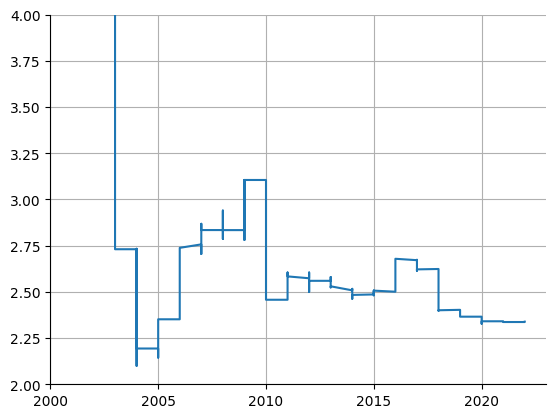

In [5]:
dp = df.sort_values(by='ref_year')
dp['count_male'].value_counts()
# plt.plot(dp['ref_year'], np.cumsum(dp['count_male']))
# plt.plot(dp['ref_year'], np.cumsum(dp['count_female']))
plt.plot(dp['ref_year'], np.cumsum(dp['count_male']) / np.cumsum(dp['count_female']))
plt.grid()
plt.xlim(2000, 2023)
plt.ylim(2, 4)